In [1]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 2.1 MB 4.7 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 KB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72858 sha256=2f00ca4f7fe73b05bbfa620f5208e00cb6ae22290e6750a7236422d56c9dfde2
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle


In [2]:
import pandas as pd 
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
!pip install pydicom
import pydicom as dcm
%matplotlib inline 
IS_LOCAL = False
import os

import csv
import random

import numpy as np
import pandas as pd
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
PATH = '/content'
os.listdir(PATH)

Mounted at /content/drive


['.config', 'drive', 'sample_data']

In [4]:
! mkdir ~/.kaggle

In [5]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge
! unzip rsna-pneumonia-detection-challenge.zip

Streaming output truncated to the last 5000 lines.
  inflating: stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  inflating: stage_2_train_images/d539e101-5662-445c-9f6a-381e674f0aed.dcm  
  inflating: stage_2_trai

Approach:
1. Firstly a convolutional neural network is used to segment the image, using the bounding boxes directly as a mask.
2. Secondly connected components is used to separate multiple nodules.
3. Finally a bounding box is simply drawn around every connected component.

Network
The network consists of a number of residual blocks with convolutions and downsampling blocks with max pooling.
At the end of the network a single upsampling layer converts the output to the same shape as the input.
As the input to the network is 256 by 256 (instead of the original 1024 by 1024) and the network downsamples a number of times without any meaningful upsampling (the final upsampling is just to match in 256 by 256 mask) the final prediction is very crude. If the network downsamples 4 times the final bounding boxes can only change with at least 16 pixels.

# Load patch locations (Image locations)

Creating a dictionary with Image names and locations of patches.

Table contains [filename : patch location] pairs per row.

If a filename contains multiple patches, the table contains multiple rows with the same filename but different nodule locations.
If a filename contains no nodules it contains a single row with an empty nodule location.
The code below loads the table and transforms it into a dictionary.

The dictionary uses the filename as key and a list of patch locations in that filename as value.
If a filename is not present in the dictionary it means that it contains no nodules.

In [7]:
# Patches
# empty dictionary
patch_locations = {}
# load table
with open(os.path.join(PATH+'/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        patch = rows[5]
       # print(filename, location, nodule)
        # if row contains a nodule add label to dictionary
        # which contains a list of nodule locations per filename
        if patch == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save nodule location in dictionary
            if filename in patch_locations:
                patch_locations[filename].append(location)
            else:
                patch_locations[filename] = [location]

# Load filenames

In [8]:
# load and shuffle filenames
folder = PATH+'/stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('No. of train samples', len(train_filenames))
print('No. of validation samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

No. of train samples 24124
No. of validation samples 2560


No. of train samples 24124
No. of validation samples 2560

# Exploration

Total train images: 26684
Images with nodule: 6012


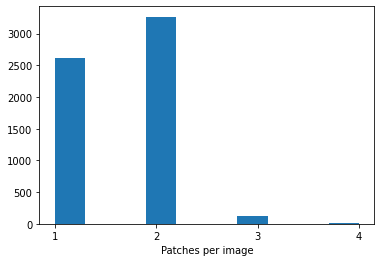

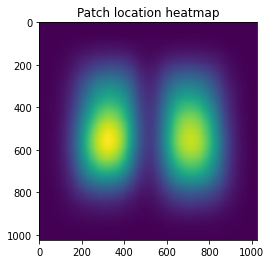

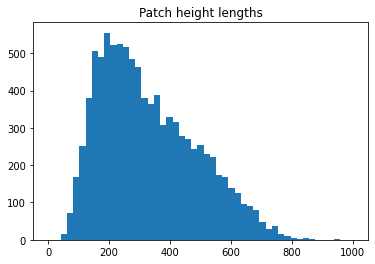

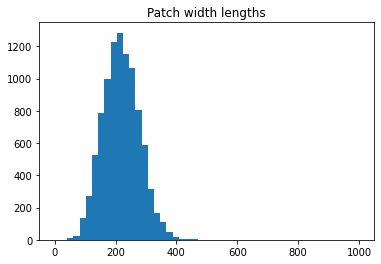

Minimum Patch height: 45
Minimum Patch width:  40


In [9]:
print('Total train images:',len(filenames))
print('Images with nodule:', len(patch_locations))

ns = [len(value) for value in patch_locations.values()]
plt.figure()
plt.hist(ns)
plt.xlabel('Patches per image')
plt.xticks(range(1, np.max(ns)+1))
plt.show()

heatmap = np.zeros((1024, 1024))
ws = []
hs = []
for values in patch_locations.values():
    for value in values:
        x, y, w, h = value
        heatmap[y:y+h, x:x+w] += 1
        ws.append(w)
        hs.append(h)
plt.figure()
plt.title('Patch location heatmap')
plt.imshow(heatmap)
plt.figure()
plt.title('Patch height lengths')
plt.hist(hs, bins=np.linspace(0,1000,50))
plt.show()
plt.figure()
plt.title('Patch width lengths')
plt.hist(ws, bins=np.linspace(0,1000,50))
plt.show()
print('Minimum Patch height:', np.min(hs))
print('Minimum Patch width: ', np.min(ws))

[195.74904817 227.83976163]
[257.53386454 503.64029596]


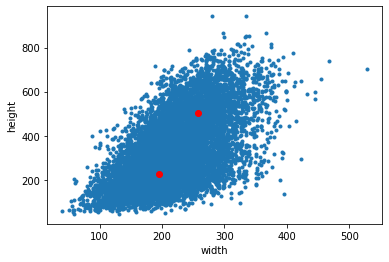

In [10]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(np.array([ws, hs]).T)
centers = kmeans.cluster_centers_
plt.figure()
plt.scatter(ws, hs, marker='.')
plt.xlabel('width')
plt.ylabel('height')
for center in centers:
    print(center)
    plt.scatter(center[0], center[1], c='red')
plt.show()

#Data generator

The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.

The generator takes in some filenames, batch_size and other parameters.

The generator outputs a random batch of numpy images and numpy masks.

In [11]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, nodule_locations=None, batch_size=32, image_size=512, shuffle=True, predict=False, augment = False):
        self.folder = folder
        self.filenames = filenames
        self.nodule_locations = nodule_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment
        self.shuffle = shuffle
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = dcm.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains nodules
        if filename in patch_locations:
            # loop through nodules
            for location in patch_locations[filename]:
                # add 1's at the location of the nodule
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = dcm.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

#BatchNormalization

In [12]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization()(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization()(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=5):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Train network

In [13]:
# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=.01),loss=keras.losses.binary_crossentropy,metrics=['accuracy', mean_iou])

# create train and validation generators
folder = PATH+'/stage_2_train_images'
train_gen = generator(folder, train_filenames, patch_locations, batch_size=32, image_size=256, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, patch_locations, batch_size=32, image_size=256, shuffle=False, predict=False)

history = model.fit(train_gen, validation_data=valid_gen, epochs=1, shuffle=True, verbose=1)

753/753 [==============================] - 41799s 55s/step - loss: 0.0999 - accuracy: 0.9712 - mean_iou: 0.7694 - val_loss: 0.1392 - val_accuracy: 0.9734 - val_mean_iou: 0.7864


753/753 [==============================] - 33729s 45s/step - loss: 0.1011 - accuracy: 0.9732 - mean_iou: 0.7728 - val_loss: 0.0991 - val_accuracy: 0.9726 - val_mean_iou: 0.7673

In [14]:
model.save("/content/drive/MyDrive/Learning/AI ML Great Learning/Projects/Capstone project - CV1/Solution/model_CNN.h5")

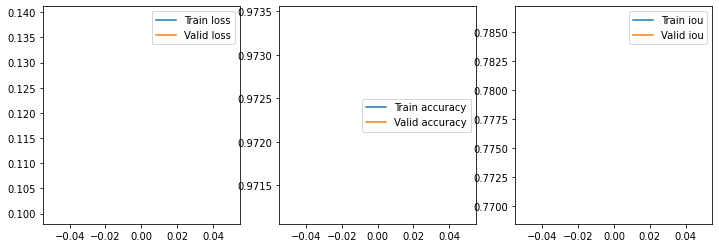

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

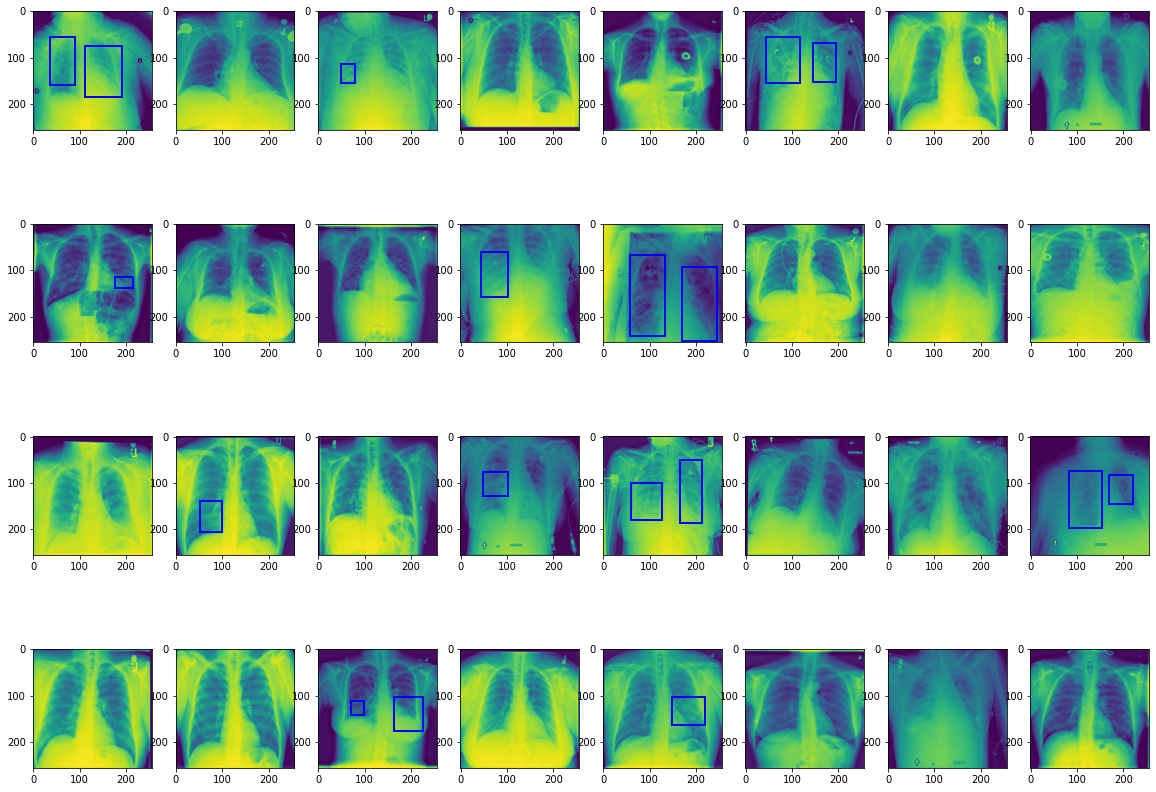

In [16]:
import matplotlib.patches as patches

for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

# Predict test images

In [ ]:
# load and shuffle filenames
folder = PATH+'/stage_2_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=25, image_size=256, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('/content/drive/MyDrive/Learning/AI ML Great Learning/Projects/Capstone project - CV1/Solution/submission_CNN.csv')

n test samples: 3000
